In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as seabornInstance
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn import metrics

import random
import time
import pickle
import sys

In [2]:
np.random.seed(42)
random.seed(42)

In [3]:
dataset = pd.read_csv('moviefeature.csv')
print(dataset.shape, type(dataset))
dataset.describe()

(2892, 70) <class 'pandas.core.frame.DataFrame'>


,tmdb_id,popularity,runtime,vote_average,vote_count,adult_False,original_language_af,original_language_ar,original_language_bg,original_language_bn,...,genres_History,genres_Horror,genres_Music,genres_Mystery,genres_Romance,genres_Science Fiction,genres_TV Movie,genres_Thriller,genres_War,genres_Western
count,2892.000000,2.892000e+03,2.892000e+03,2.892000e+03,2.892000e+03,2892.0,2892.000000,2892.000000,2892.000000,2892.000000,...,2892.000000,2892.000000,2892.000000,2892.000000,2892.000000,2892.000000,2892.000000,2892.000000,2892.000000,2892.000000
mean,60207.090249,-1.502794e-15,1.165888e-16,1.020611e-14,-5.344772e-17,1.0,0.000346,0.001037,0.000346,0.001383,...,0.008645,0.037344,0.008645,0.013140,0.023167,0.010373,0.005533,0.028354,0.011065,0.009336
std,67132.680364,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.0,0.018595,0.032197,0.018595,0.037171,...,0.092589,0.189637,0.092589,0.113893,0.150461,0.101338,0.074188,0.166011,0.104625,0.096188
min,15.000000,-6.282668e-01,-1.989656e+00,-4.114135e+00,-2.565453e-01,1.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,14590.750000,-5.200863e-01,-3.271541e-01,-3.033649e-01,-2.492199e-01,1.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,38385.500000,-3.153526e-01,-1.424317e-01,1.565556e-01,-2.333484e-01,1.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,78497.500000,3.094352e-01,1.346519e-01,5.507733e-01,-1.646736e-01,1.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,421510.000000,2.810191e+01,2.121148e+01,2.456158e+00,1.692743e+01,1.0,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
y = dataset['popularity'].values.reshape(-1,1)
X = dataset.drop(['popularity'],axis=1).values


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
clf = Lasso(alpha=1.0)
clf.fit(X, y) 

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# Calculate accuracy of linear regression lasso
parameters = {'alpha':np.arange(0.1,100,0.1)}
linear_model = Lasso()
clf = GridSearchCV(linear_model, parameters, cv=5, scoring='neg_mean_squared_error')
clf.fit(X_train, y_train)
print(clf.best_params_, clf.best_score_)
print("The MSE of linear regression is: %f"%(-clf.best_score_))

# Calculate accuracy of random forest regression
parameters = {'max_depth':range(1,10),'n_estimators':range(1,10)}
clf = GridSearchCV(RandomForestRegressor(), parameters, cv=5, scoring='neg_mean_squared_error')
clf.fit(X_train, y_train.ravel())
print(clf.best_params_, clf.best_score_)
print("The MSE of random forest regression is: %f"%(-clf.best_score_))


{'alpha': 0.1} -0.51832935832079
The MSE of linear regression is: 0.518329
{'n_estimators': 7, 'max_depth': 4} -0.31969276911499334
The MSE of random forest regression is: 0.319693


In [7]:
def generate_fake_data(X, axis_num, ratio):
    res = np.concatenate((X, X), axis=axis_num)
    for i in range(ratio):
        res = np.concatenate((res, res), axis=axis_num)
    return res

In [8]:
def evaluation(iteration, model1, model2, orginal_X, original_Y, axis_num):
    # model size
    m1_model_size, m2_model_size = [], []
    # training time
    m1_training_time, m2_training_time = [], []
    # inference time
    m1_inference_time, m2_inference_time = [], []
    # sample number
    sample_num = []
    # feature num
    feature_num = []
    
    for i in range(iteration):
        print("the %d iteration"%i)
        X_large_sample_num = generate_fake_data(orginal_X,axis_num,ratio=i)
        if axis_num == 0:
            y_large_sample_num = generate_fake_data(original_Y,axis_num,ratio=i)
        else:
            y_large_sample_num = original_Y
        sample_num.append(X_large_sample_num.shape[0])
        feature_num.append(X_large_sample_num.shape[1])
        
        print(X_large_sample_num.shape, y_large_sample_num.shape)
        start_time = time.time()
        model1.fit(X_large_sample_num,y_large_sample_num)
        end_time = time.time()
        m1_training_time.append(end_time - start_time)
        p = pickle.dumps(model1)
        m1_model_size.append(sys.getsizeof(p))
        start_time = time.time()
        model1.predict(X_large_sample_num)
        end_time = time.time()
        m1_inference_time.append(end_time - start_time)

        y_large_sample_num = y_large_sample_num.ravel()
        start_time = time.time()
        model2.fit(X_large_sample_num,y_large_sample_num)
        end_time = time.time()
        m2_training_time.append(end_time - start_time)
        p = pickle.dumps(model2)
        m2_model_size.append(sys.getsizeof(p))
        start_time = time.time()
        model2.predict(X_large_sample_num)
        end_time = time.time()
        m2_inference_time.append(end_time - start_time)
        
    m1_name, m2_name = 'Linear Regression Lasso', 'Random Forest Regression'
    if axis_num==1:
        fig = plt.figure()
        ax = plt.subplot(111)
        ax.plot(feature_num,m1_training_time,label=m1_name)
        ax.plot(feature_num,m2_training_time,label=m2_name)
        ax.legend()
        plt.xlabel('feature_num', fontsize=18)
        plt.ylabel('training_time / seconds', fontsize=18)
        plt.show()

        fig = plt.figure()
        ax = plt.subplot(111)
        ax.plot(feature_num,m1_model_size,label=m1_name)
        ax.plot(feature_num,m2_model_size,label=m2_name)
        ax.legend()
        plt.xlabel('feature_num', fontsize=18)
        plt.ylabel('model_size / bytes', fontsize=18)
        plt.show()
        
        fig = plt.figure()
        ax = plt.subplot(111)
        ax.plot(feature_num,m1_inference_time,label=m1_name)
        ax.plot(feature_num,m2_inference_time,label=m2_name)
        ax.legend()
        plt.xlabel('feature_num', fontsize=18)
        plt.ylabel('inference_time / seconds', fontsize=18)
        plt.show()
    else:
        fig = plt.figure()
        ax = plt.subplot(111)
        ax.plot(sample_num,m1_training_time,label=m1_name)
        ax.plot(sample_num,m2_training_time,label=m2_name)
        ax.legend()
        plt.xlabel('sample_num', fontsize=18)
        plt.ylabel('training_time / seconds', fontsize=18)
        plt.show()

        fig = plt.figure()
        ax = plt.subplot(111)
        ax.plot(sample_num,m1_model_size,label=m1_name)
        ax.plot(sample_num,m2_model_size,label=m2_name)
        ax.legend()
        plt.xlabel('sample_num', fontsize=18)
        plt.ylabel('model_size / bytes', fontsize=18)
        plt.show()

        fig = plt.figure()
        ax = plt.subplot(111)
        ax.plot(sample_num,m1_inference_time,label=m1_name)
        ax.plot(sample_num,m2_inference_time,label=m2_name)
        ax.legend()
        plt.xlabel('sample_num', fontsize=18)
        plt.ylabel('inference_time / bytes', fontsize=18)        
        plt.show()
        
    return (m1_model_size, m2_model_size, m1_training_time, m2_training_time, 
            m1_inference_time, m2_inference_time, sample_num, feature_num)
    
        

the 0 iteration
(5784, 69) (5784, 1)
the 1 iteration
(11568, 69) (11568, 1)
the 2 iteration
(23136, 69) (23136, 1)
the 3 iteration
(46272, 69) (46272, 1)
the 4 iteration
(92544, 69) (92544, 1)
the 5 iteration
(185088, 69) (185088, 1)


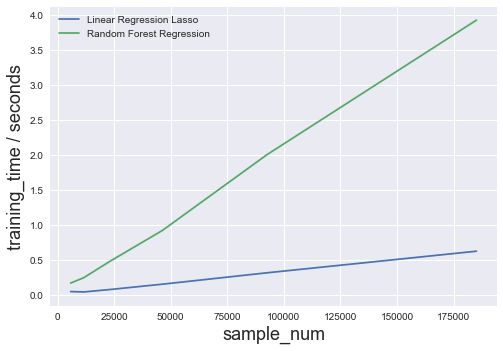

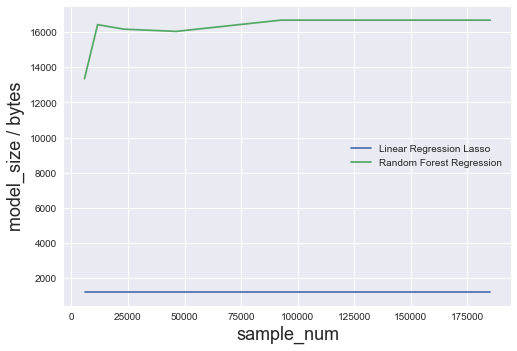

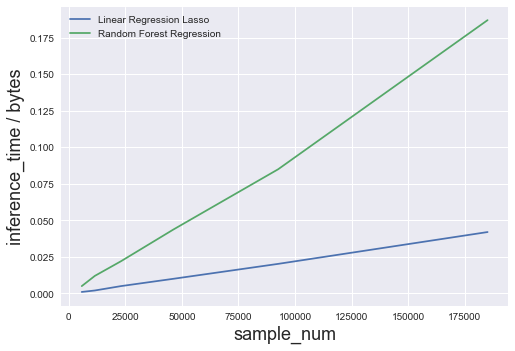

In [9]:
model1, model2 = Lasso(alpha=0.1), RandomForestRegressor(max_depth=4, n_estimators=7)

(m1_model_size, m2_model_size, m1_training_time, m2_training_time, 
m1_inference_time, m2_inference_time, sample_num, feature_num)= evaluation(6, model1, model2, X, y, 0)

the 0 iteration
(2892, 138) (2892, 1)
the 1 iteration
(2892, 276) (2892, 1)
the 2 iteration
(2892, 552) (2892, 1)
the 3 iteration
(2892, 1104) (2892, 1)
the 4 iteration
(2892, 2208) (2892, 1)
the 5 iteration
(2892, 4416) (2892, 1)


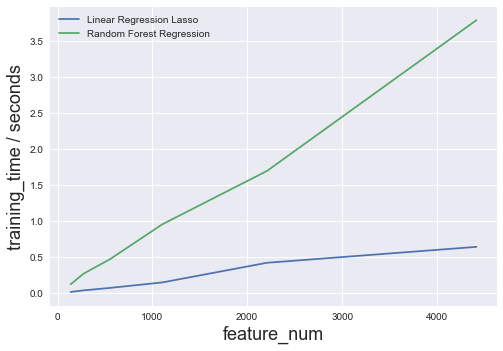

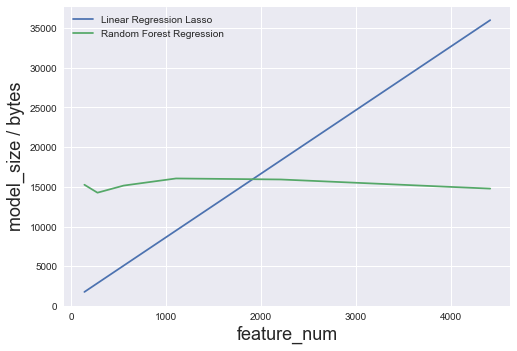

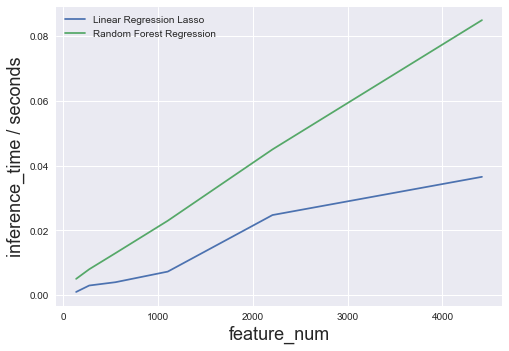

In [10]:
(m1_model_size, m2_model_size, m1_training_time, m2_training_time, 
m1_inference_time, m2_inference_time, sample_num, feature_num) = evaluation(6, model1, model2, X, y, 1)